## Ordinal Classification
### Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from mord import LogisticIT
from mord import LogisticAT
from mord import LogisticSE

from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn2pmml import sklearn2pmml
from sklearn2pmml import ColumnTransformer
from sklearn2pmml.pipeline import PMMLPipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [4]:
# Data Import
df = pd.read_csv('../../../data/winequality-white-cleaned.csv',sep=';')
# Get features and target
x = df.drop('target', axis=1)
y = df[['target']]

## Data Transformation

In [5]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=np.number)
x_numerical = sel_numeric(x)

sel_categorical = make_column_selector(dtype_exclude=np.number)
x_categorical = sel_categorical(x)

In [6]:
# Create preprocessing pipelines for numerical features
trans_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

In [7]:
# Create preprocessing pipelines for categorical features
trans_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())]
)

In [8]:
# Putting the preprocessing steps together
transformer = ColumnTransformer([
    # ('categorical', trans_categorical, x_categorical),
    ('numerical', trans_numerical, x_numerical)],
remainder='passthrough'
)

## Model Training

In [9]:
# Data Split
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
list(x_train.columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

## Multinomial Logistic Regression Model

In [11]:
# Create pipeline with logistic regression as classifier
mnlr_pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000))
])

mnlr_pipeline.fit(x_train, y_train)
mnlr_pipeline.verify(x_train.sample(n = 10))

In [12]:
y_pred = mnlr_pipeline.predict(x_test)
y_pred.view()

array([4, 9, 4, ..., 8, 7, 8])

## Multinomial Logistic Regression - Model Performance

In [13]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 65.2%
The model f1 score is: 62.9%


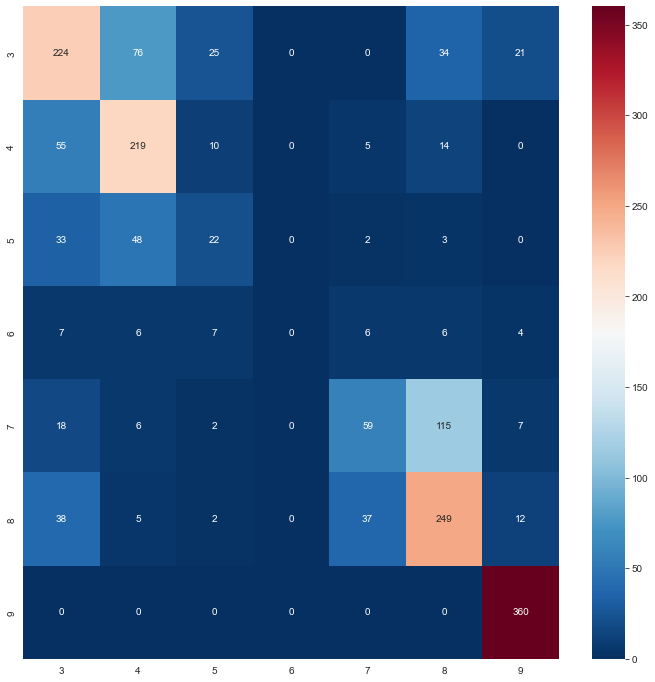

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=mnlr_pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=mnlr_pipeline.classes_, yticklabels=mnlr_pipeline.classes_, fmt='g', annot=True)
plt.show()

As we can observer, the diagonal value is the highest value for each row which means we have a good classifier.

## mord LogisticIT Model

In [15]:
# Create pipeline with logistic regression as classifier
mord_pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', LogisticIT(alpha=1.0))
])

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

mord_pipeline.fit(x_train, y_train_le)
mord_pipeline.verify(x_train.sample(n = 10))

In [16]:
y_pred = mord_pipeline.predict(x_test)
y_pred = le.inverse_transform(y_pred)
y_pred.view()

array([3, 9, 4, ..., 9, 8, 9])

##  mord LogisticIT - Model Performance

In [17]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 47.4%
The model f1 score is: 40.5%


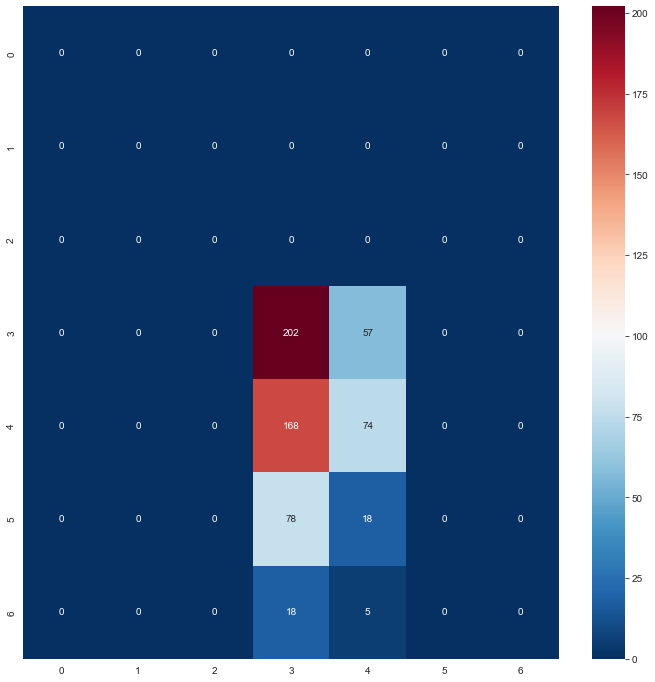

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=mord_pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=mord_pipeline.classes_, yticklabels=mord_pipeline.classes_, fmt='g', annot=True)
plt.show()

## Ordered probit model

In [19]:
# Define ordered probit model taking the cut variable as our target and volume, price, and carat as independent variables.
mod_probit = OrderedModel(y_train[list(y_train.columns)],
                          x_train[list(x_train.columns)],
                          distr='probit')

res_probit = mod_probit.fit(method='bfgs')
res_probit.summary()

Optimization terminated successfully.
         Current function value: 1.450201
         Iterations: 117
         Function evaluations: 124
         Gradient evaluations: 124


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 target   Log-Likelihood:                -10075.
Model:                   OrderedModel   AIC:                         2.018e+04
Method:            Maximum Likelihood   BIC:                         2.030e+04
Date:                Thu, 06 Apr 2023                                         
Time:                        16:51:12                                         
No. Observations:                6947                                         
Df Residuals:                    6930                                         
Df Model:                          17                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.5033      0.027     18.630      0.000       0.450       0.556
volatile acidity        -1.0864      0.141     -7.689      0.000      -1.363      -0.809
citric acid              2.1161      0.158     13.369      0.000       1.806       2.426
residual sugar           0.2455      0.011     22.422      0.000       0.224       0.267
chlorides               -2.3081      0.813     -2.839      0.005      -3.901      -0.715
free sulfur dioxide     -0.0067      0.001     -7.903      0.000      -0.008      -0.005
total sulfur dioxide    -0.0002      0.000     -0.404      0.686      -0.001       0.001
density               -520.0228     30.913    -16.822      0.000    -580.612    -459.434
pH                       4.4058      0.148     29.741      0.000       4.115       4.696
sulphates                1.6349      0.143     11.400      0.000       1.354       1.916
alcohol                 -0.0230      0.041     -0.565      0.572      -0.103       0.057
3/4                   -498.1228     30.579    -16.290      0.000    -558.056    -438.190
4/5                     -0.2978      0.025    -11.885      0.000      -0.347      -0.249
5/6                     -1.2388      0.045    -27.610      0.000      -1.327      -1.151
6/7                     -2.4930      0.090    -27.555      0.000      -2.670      -2.316
7/8                     -0.5601      0.031    -18.166      0.000      -0.621      -0.500
8/9                     -0.1190      0.025     -4.854      0.000      -0.167      -0.071
========================================================================================
"""

In [20]:
# Prediction
predicted = res_probit.model.predict(res_probit.params, exog=x_test[list(x_train.columns)])
predicted

array([[0.41874502, 0.28573694, 0.09141451, ..., 0.11216392, 0.06039662,
        0.00892515],
       [0.00244938, 0.0167218 , 0.01824763, ..., 0.08505486, 0.27550789,
        0.59475818],
       [0.36291611, 0.28946808, 0.09983286, ..., 0.13149907, 0.07778728,
        0.01310321],
       ...,
       [0.0021804 , 0.01531911, 0.01698275, ..., 0.08075809, 0.26885043,
        0.60910844],
       [0.05503529, 0.1411197 , 0.08963775, ..., 0.22056859, 0.30035482,
        0.16454759],
       [0.00924672, 0.04410954, 0.03949003, ..., 0.14420333, 0.33482401,
        0.41362631]])

In [21]:
y_pred = predicted.argmax(axis=1)
y_pred = pd.DataFrame(y_pred,columns=['target'])
target_map = {0:3, 1:4, 2:5, 3:6, 4:7, 5:8, 6:9}
y_pred['target'] = y_pred['target'].map(target_map)
y_pred

,target
0,3
1,9
2,3
3,4
4,8
...,...
1732,3
1733,8
1734,9
1735,8


## Ordered probit - Model Performance

In [22]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 43.5%
The model f1 score is: 38.0%


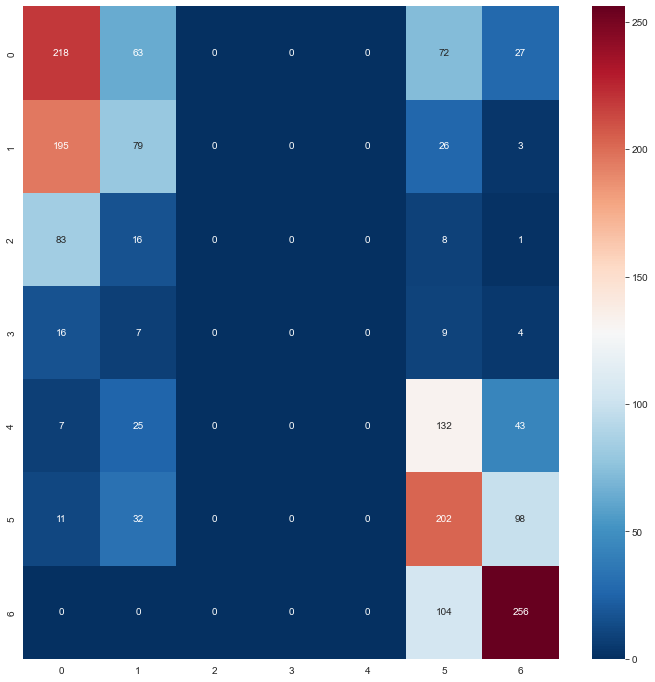

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", fmt='g', annot=True)
plt.show()

## Model Selection

As shown from the models performance,  Multinomial Logistic Regression is the best model

## Save the mode

In [25]:
# Save the best model in PMML format
sklearn2pmml(mnlr_pipeline, "../../../data/OrdinalLogisticRegression.pmml")